# Mental Health Survey Exploratory Analysis

The purpose of this project is to carry out an exploratory analysis on data from a mental health survey. The survey was taken in 2014 by people who work in tech. Available [here](https://www.kaggle.com/osmi/mental-health-in-tech-survey), it measures attitudes towards mental health and frequency of mental health disorders in the tech workplace. Some questions include:
- Have you sought treatment for a mental health condition?
- Does your employer provide mental health benefits?
- Would you be willing to discuss a mental health issue with your coworkers?

The scope of the dataset is pretty wide, covering over 20 variables. The goal of _this_ project is to use Principle Component Analysis to break these many variables into few and pursue a higher level understanding of any trends or behavior.

In [1]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
## Read in the data file

df = pd.read_csv('survey.csv')
df.shape

(1259, 27)

In [3]:
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


**Observations**
- We have primarily categorical data.
- Some fields contain binary ```Yes```/```No``` responses while others range from ```Somewhat easy``` to ```Somewhat difficult```. We will need to scale this data.
- There are missing values to address.

### Preliminary Visualizations
Let's start with a few simple plots to get an idea of any patterns. We'll condiser the variable ```treatment``` which is defined as **_Have you sought treatment for a mental health condition?_** and is answered with ```Yes``` or ```No```.

In [4]:
## Set the style of our plots
sns.set_style('darkgrid')
sns.set_palette('pastel')

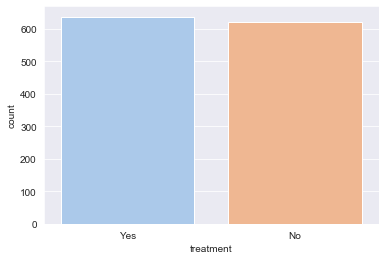

In [5]:
sns.countplot(x=df['treatment'])

- Close to a 50/50 split

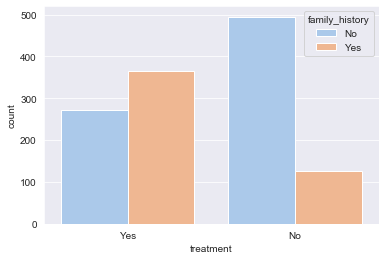

In [6]:
sns.countplot(x=df['treatment'],hue=df['family_history'])

- Respondents reporting a mental condition also report a higher association with family history of mental illness
- Medical findings support the theory that there may be some hereditary components to mental illness (see [this article](https://www.webmd.com/mental-health/mental-health-causes-mental-illness#1))

## Missing Values
Before we can run PCA analysis or any machine learning algorithms for that matter, we will need to address missing values. For columns that are replete with missing data, we can simply drop the column entirely. For those with a smaller percentage of nans, imputing missing values could be viable.

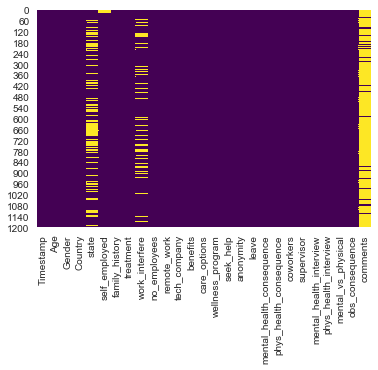

In [6]:
## Visualize the missing data
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [7]:
## Display the column-wide percentages of missing data.
null = df.isnull().sum()
(null[null!=0]/len(df)).sort_values(ascending=False)

comments          0.869738
state             0.409055
work_interfere    0.209690
self_employed     0.014297
dtype: float64

Let's toss out ```comments``` as there is not enough data here to draw any meaningful insight. We'll go ahead and toss out ```states``` as well for the sake of a more complete analysis. For an overview of just the United States, this would be a good variable to keep.

Nuke ```Timestamp``` while we're at it.

In [8]:
df = df.drop(['state','comments','Timestamp'],axis=1)

### Impute Missing Values

The variables ```work_interfere``` and ```self_employed``` have a workable number of missing values so they are good candidates for imputation. 
    
- For ```self-employed``` we can simply fill in the na's with the most common value.
- For ```work_interfere``` let's find the most common response stratifying by whether a person has a condition in the first place.

### Self-employed

In [9]:
df['self_employed'].value_counts()

No     1095
Yes     146
Name: self_employed, dtype: int64

In [10]:
df['self_employed'] = df['self_employed'].fillna('No')

### Work-interfere

In [11]:
## People with no condition
df[df['treatment']=='No']['work_interfere'].value_counts(dropna=False)

NaN          260
Never        183
Sometimes    107
Rarely        51
Often         21
Name: work_interfere, dtype: int64

There were alot of nans among this group, understanably so, becuase the question is geared towards those _with_ a mental health condition. For this group we'll fill in ```Never```.

In [12]:
## People with a condition
df[df['treatment']=='Yes']['work_interfere'].value_counts(dropna=False)

Sometimes    358
Often        123
Rarely       122
Never         30
NaN            4
Name: work_interfere, dtype: int64

For these we'll replace nans with ```Sometimes```.

In [13]:
condition = df[df['treatment']=='Yes']
nc = df[df['treatment']=='No']

nc['work_interfere'] = nc['work_interfere'].fillna('Never')
condition['work_interfere'] = condition['work_interfere'].fillna('Sometimes')

df = pd.concat([condition,nc],axis=0)

/Users/wynnephilpott/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/wynnephilpott/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


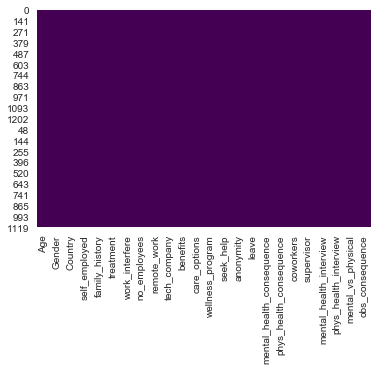

In [14]:
## All purple means no missing data
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

## Feature Preparation

Lets first take a look at how many unique values there are in each column.

In [15]:
for col in df.columns:
    print(col,df[col].nunique(),sep='\t')

Age	53
Gender	49
Country	48
self_employed	2
family_history	2
treatment	2
work_interfere	4
no_employees	6
remote_work	2
tech_company	2
benefits	3
care_options	3
wellness_program	3
seek_help	3
anonymity	3
leave	5
mental_health_consequence	3
phys_health_consequence	3
coworkers	3
supervisor	3
mental_health_interview	3
phys_health_interview	3
mental_vs_physical	3
obs_consequence	2


Goodness gracious that is a lot of genders. For now we will remove that field all together. 

Keep in mind that the end goal here is to run a PCA and to do so, we need to encode the ```Yes```,```No```, ```Maybe``` responses as 0s, 1s, 2s and so on. Encoding a country does not make a lot of sense as the data is not ordinal (living in ```Australia - 0``` is not "less than" living in ```Canada - 4```. Let's drop the country column for the sake of our desired analysis. Using ```Country``` for exploratory visualizations is a good idea for another day.

In [16]:
df.drop(['Gender','Country'],axis=1,inplace=True)

## Encode the Responses
Now we will turn string variables such as ```Yes```, ```No```, ```Rarely```, ```More than 1000``` into numbers that the computer can understand. To accomplish this, we will us scikit-learn's LabelEncoder package.

In [17]:
from sklearn.preprocessing import LabelEncoder

def encode_df(dataframe):
    le = LabelEncoder()
    for col in dataframe.columns:
        dataframe[col] = le.fit_transform(dataframe[col])
    return dataframe

In [18]:
df.head()

,Age,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,No,No,Yes,Often,6-25,No,Yes,Yes,Not sure,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
3,31,No,Yes,Yes,Often,26-100,No,Yes,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
6,35,No,Yes,Yes,Sometimes,1-5,Yes,Yes,No,No,...,No,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No
8,42,No,Yes,Yes,Sometimes,100-500,No,Yes,Yes,Yes,...,No,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No
10,31,No,No,Yes,Sometimes,6-25,Yes,Yes,Don't know,No,...,Don't know,Don't know,No,No,Some of them,Yes,No,No,Don't know,No


In [19]:
df = encode_df(df)

In [20]:
df.head()

,Age,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,25,0,0,1,1,4,0,1,2,1,...,2,2,1,1,1,2,1,0,2,0
3,19,0,1,1,1,2,0,1,1,2,...,1,1,2,2,1,0,0,0,1,1
6,23,0,1,1,3,0,1,1,1,0,...,1,1,0,0,1,0,1,1,0,0
8,30,0,1,1,3,1,0,1,2,2,...,1,3,0,1,2,2,1,0,1,0
10,19,0,0,1,3,4,1,1,0,0,...,0,0,1,1,1,2,1,1,0,0


### Scale the Data
The final step before running any sort of analysis is to scale the data. Recall that some of the columns vary from 0 to 1 while other columns range from 0 to 6 and ```Age``` even more so from 20 to 50.

If we input the data as is, the computer's algorithms will take these ranges into consideration and weight the variables according to how extreme the values are. This can result in exaggerated or incomprehensible patterns in our output. 

A quick solution is to scale the data so each column is weighted evenly.

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)

scale = scaler.transform(df)

In [25]:
scale

array([[ 6.77695855e-01, -3.62183654e-01, -8.00912127e-01, ...,
        -9.92534419e-01,  1.42080290e+00, -4.13718250e-01],
       [-1.37741305e-01, -3.62183654e-01,  1.24857643e+00, ...,
        -9.92534419e-01,  2.21881418e-01,  2.41710391e+00],
       [ 4.05883468e-01, -3.62183654e-01,  1.24857643e+00, ...,
         3.89767388e-01, -9.77040063e-01, -4.13718250e-01],
       ...,
       [-1.83511143e-03, -3.62183654e-01, -8.00912127e-01, ...,
         1.77206919e+00, -9.77040063e-01, -4.13718250e-01],
       [ 5.41789662e-01, -3.62183654e-01,  1.24857643e+00, ...,
         3.89767388e-01, -9.77040063e-01, -4.13718250e-01],
       [ 1.90085159e+00, -3.62183654e-01, -8.00912127e-01, ...,
         3.89767388e-01,  2.21881418e-01, -4.13718250e-01]])

# Principle Component Analysis

PCA is a technique that uses linear algebra to transform high-dimensional data into lower dimensional data. More specifically we could use PCA to take a 2-dimensional snapshot of say a 22 dimensional survey dataset, plot it and hopefully be able to visualize patterns.

A full explanation of how PCA works and why is beyond the scope of this project but to summarize, its core concept is to maximize variation of the original data across the components of a lower dimensional snapshot. The number of components chosen is up to the analyst.

- [This](https://setosa.io/ev/principal-component-analysis/) hands-on article provides a great visual comprehension of PCA
- And [this video](https://www.youtube.com/watch?v=FgakZw6K1QQ) does a great job explaining its concepts

In our case, we will use 2 components so we can picture the data on a 2-dimensional graph.

In [108]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scale)
x_pca = pca.transform(scale)

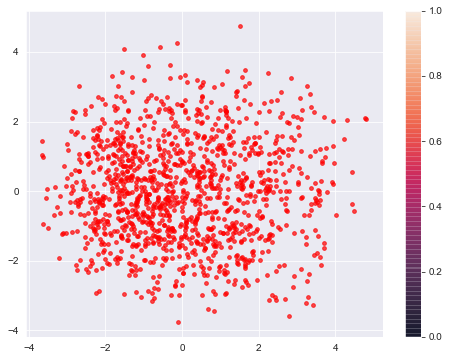

In [109]:
plt.figure(figsize=(8,6)) 
plt.scatter(x_pca[:,0],x_pca[:,1],c='red',s=14,alpha=.7)
plt.colorbar()

By itself, the graph does not reveal much. This is just what a 22 dimensional dataset looks like in 2 dimensions when the camera is positioned at an angle so that variation in the data is maximized across the x-axis first and the y-axis second.

Let's overlap some relevant variables over this plot and see what we see.

We'll map treatment onto the plot first, recall that this variable is defined as **_Have you sought treatment for a mental health condition?_**. 

To avoid "cheating" so to speak, we will drop the `treatment` column from our dataset all together. That way the PCA has no prior knowledge of where the `Yes`'s are and where the `No`'s are.

The hope, is that they cluster in a similar fashion.

In [112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df.drop('treatment',axis=1))

scale = scaler.transform(df.drop('treatment',axis=1))

In [113]:
pca = PCA(n_components=2)
pca.fit(scale)
x_pca = pca.transform(scale)

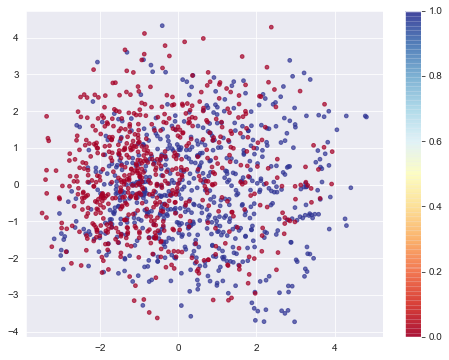

In [114]:
plt.figure(figsize=(8,6)) 
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['treatment'],cmap='RdYlBu',s=14,alpha=.7)
plt.colorbar()

## Linear Algebra!!

- Reds are people who have not sought treatment for a mental condition
- Blues are those who have sought treatment 
- Reds cluster towards the left, on the negative side of principle component 1
- Blues tend more to the center

How cool is it that even without the `treatment` column factored in, the PCA decomposition can detect that people _with_ a mental condition cluster one way and those _without_ cluster a different way. By maximizing the variation across component one, indeed those without a condition ended up on one side of the component while those with a condition ended up differently. 

What hypotheses can we potentially construct with this information? 
- Perhaps people with a mental condition have one similar overall outlook on mental illness while those without a mental condition share another. 
- Maybe people with mental illness find themselves at companies more sensitive to mental illness (has benefits, has a wellness program etc.) and people without are indifferent and this is reflected in the survey.
- There is a latent factor behind why people responded to the survey the way they did that ties in with whether they have a mental condition or not.

**Note -** This is just an exploratory analysis, for something more we'd need to go deeper perhaps by testing for multicollinearity, determining if there are extant linear or non-linear factors, and fitting predicitve models. It is remarkable though that we can pick up on potential latent behavior in the data with this powerful tool.

## Other Plots

- Would you be willing to discuss a mental health issue with your direct supervisor(s)? **(Yes, No, Some of them)**

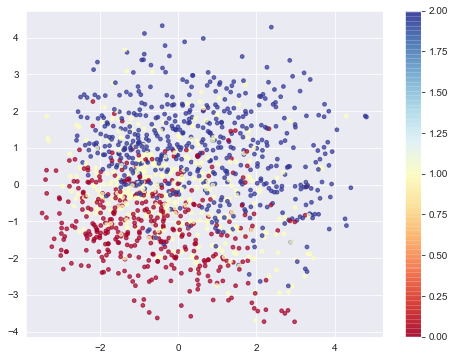

In [125]:
plt.figure(figsize=(8,6)) 
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['supervisor'],cmap='RdYlBu',s=14,alpha=.7)
plt.colorbar()

- Would you be willing to discuss a mental health issue with your coworkers? **(Yes, No, Some of them)**

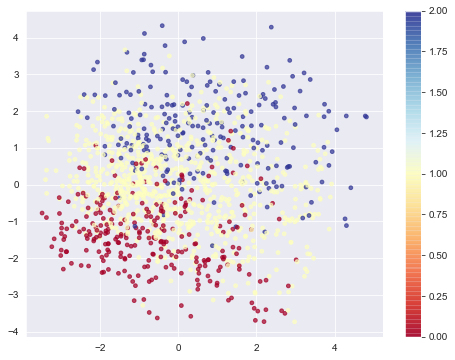

In [122]:
plt.figure(figsize=(8,6)) 
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['coworkers'],cmap='RdYlBu',s=14,alpha=.7)
plt.colorbar()

- Does your employer provide resources to learn more about mental health issues and how to seek help? **(Yes, No, Don't know)**

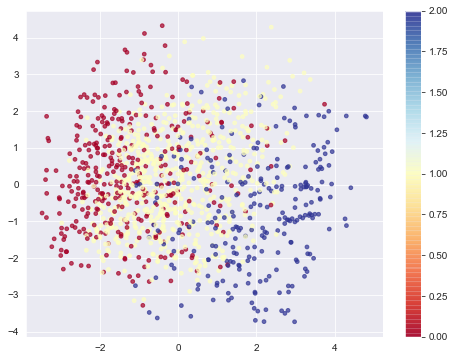

In [126]:
plt.figure(figsize=(8,6)) 
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['seek_help'],cmap='RdYlBu',s=14,alpha=.7)
plt.colorbar()